# Bayesian A/B testing

In [33]:
import scipy.stats as scs
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

In [34]:
image_file_name = "bayesian_images"

In [35]:
if not image_file_name in os.listdir():
    os.mkdir("bayesian_images")

__The use-case__

One wants to compare the performances between two actions. For instance one wants to know if it is worth displaying an advertisment at the begining of a video. To answer this question we will display the advertisment to a random group of customers (group A let's say) and to the other customers we will display nothing. Then we will get the conversion rate in each group and statistically test if the group to which the advertisment has been diplayed convert more or not. 

## The bayesian approach of the problem

Sources : 
* https://medium.com/convoy-tech/the-power-of-bayesian-a-b-testing-f859d2219d5
* https://cdn2.hubspot.net/hubfs/310840/VWO_SmartStats_technical_whitepaper.pdf

This approach use the bayesian rules to update, all along the test, the assumption about the distribution of law probability about the conversion rate for each group.

One will then have distributions of conversion rate's probabilities for each group that will get sharper along the test. These distributions will then be used to decide if one can stop the test and choose the better option with a good confidence.

For instance, let's use Beta distributions. At the beginning we will use $(1,1)$ as parameters so that we have a uniform distribution. Then the more we will get data, de more sharpe will be our distributions.

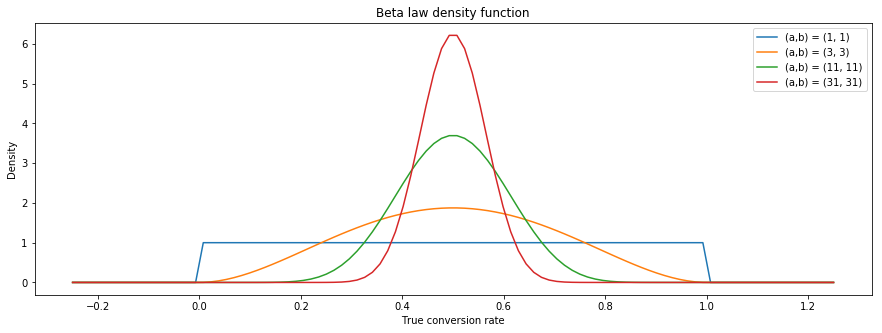

In [36]:
params_values = [(1, 1), (3, 3), (11, 11), (31, 31)]

plt.figure(figsize=(15, 5))

for a, b in params_values:
        prior_beta_law = scs.beta(a, b)
        x = np.linspace(-0.25, 1.25, 100)
        plt.plot(x, prior_beta_law.pdf(x))

plt.title("Beta law density function")
plt.legend(["(a,b) = {}".format(x) for x in params_values])
plt.xlabel("True conversion rate")
plt.ylabel("Density")
plt.savefig("{}/density_beta_groupe2.png".format(image_file_name, a, b))
plt.show()

## Code to perform the test

The true conversion rate in groupe A is called $\lambda_A$, the one the group B is $\lambda_B$

We will make a fake example by choosing a true conversion rate of $\lambda_A = 0.5$ for group A and a true conversion rate of $\lambda_B = 0.4$ for group B.

As mentionned before, the prior for each group is a Beta law with parameters $(1,1)$.

We sample 10 000 points for four groups.

In [37]:
if not "data" in os.listdir("../"):
    os.mkdir("../data")
    
    lambda_a = 0.41
    lambda_b = 0.4
    lambda_c = 0.6
    lambda_d = 0.6001

    results_a = np.random.binomial(1, lambda_a, 10000)
    results_b = np.random.binomial(1, lambda_b, 10000)
    results_c = np.random.binomial(1, lambda_c, 10000)
    results_d = np.random.binomial(1, lambda_d, 10000)

    data_test = pd.DataFrame({"A": results_a,
                          "B": results_b,
                          "C": results_c,
                          "D": results_d})

    data_test.to_csv("../data/data_test_example_0.csv", index=False)
    data_test = pd.read_csv("../data/data_test_example_0.csv")

We compute the posterior laws thanks to the information given by the results. The posterior density functions are called respectivelly $f_A$ and $f_B$.

In [38]:
def compute_posterior_laws(results_a, results_b,
                           prior_alpha_a=1, prior_beta_a=1, 
                           prior_alpha_b=1, prior_beta_b=1):
    
    posterior_alpha_a = prior_alpha_a + np.sum(results_a)
    posterior_beta_a = prior_beta_a + len(results_a) - np.sum(results_a)

    posterior_alpha_b = prior_alpha_b + np.sum(results_b)
    posterior_beta_b = prior_beta_b + len(results_b) - np.sum(results_b)
    
    posterior_law_a = scs.beta(posterior_alpha_a, posterior_beta_a)
    posterior_law_b = scs.beta(posterior_alpha_b, posterior_beta_b)
    
    return posterior_law_a, posterior_law_b

In [39]:
posterior_law_a, posterior_law_b = compute_posterior_laws(results_a, results_b,
                                                          prior_alpha_a, prior_beta_a, 
                                                          prior_alpha_b, prior_beta_b)

Thanks to the law we can compute the probability that the conversion rate belong to a small intervalle.

In [40]:
def compute_posterior_probs(posterior_law_a, posterior_law_b, steps=100):
    
    posterior_a = []
    posterior_b = []
    
    for i in range(steps):
        inf_ = i * (1 / (steps))
        sup_ = (i + 1) * (1 / (steps))
        posterior_a.append(posterior_law_a.cdf(sup_) - posterior_law_a.cdf(inf_))
        posterior_b.append(posterior_law_b.cdf(sup_) - posterior_law_b.cdf(inf_))
    
    return posterior_a, posterior_b

In [41]:
posterior_a, posterior_b = compute_posterior_probs(posterior_law_a, posterior_law_b, steps=100)

Once we have the posterior information, we will joint them to and get a joint density function $f_{A,B}$ such as :
$$ \forall(x_A, x_B) \in [0,1]^2, f_{A,B}(x_A, x_B) = f_A(x_A).f_B(x_B)$$

In [42]:
def compute_joint_posterior_probs(posterior_a, posterior_b, steps=100):
    
    posterior_joint = np.zeros((steps, steps))
    
    for i in range(steps):
        for j in range(steps):
            posterior_joint[i, j] = posterior_a[i] * posterior_b[j]
            
    return posterior_joint

In [43]:
posterior_joint_probs = compute_joint_posterior_probs(posterior_a, posterior_b)

Then we can compute $P(\lambda_A > \lambda_B)$ and $P(\lambda_B < \lambda_A)$ given by :
$$P(\lambda_B > \lambda_A)   = \displaystyle\int_0^1\int_{x_A}^{1} f_{A,B}(x_A, x_B)d x_B dx_A$$

and 

$$P(\lambda_A > \lambda_B)   = \displaystyle\int_0^1\int_{x_B}^{1} f_{A,B}(x_A, x_B)d x_A dx_B$$

We can be use to estimate the probability of being when concidering a result for the test.

But a great error should have a greater weight that a small one, because the consequencies are worse. This is why we use a loss function taking into account the difference between $\lambda_A$ and $\lambda_B$

If we find $\lambda_A >\lambda_B$ we will compute the following loss :
$$E\big[\max(\lambda_B - \lambda_A, 0) | n_A, n_B, c_A, c_B\big]   = \displaystyle\int_0^1\int_{x_A}^{1} (x_B-x_A).f_{A,B}(x_A, x_B)d x_B dx_A$$

and conversly we will compute that one if we find the opposite :
$$E\big[\max(\lambda_A - \lambda_B, 0) | n_A, n_B, c_A, c_B\big]   = \displaystyle\int_0^1\int_{x_B}^{1} (x_A-x_B).f_{A,B}(x_A, x_B)d x_A dx_B$$

In [44]:
def compute_error_probability(posterior_joint_probs, steps):
        
    proba_b_sup_a = 0
    for i in range(steps):
        for j in range(i + 1, steps):
            proba_b_sup_a += posterior_joint_probs[i, j]
            
    proba_a_sup_b = 0
    for i in range(steps):
        for j in range(0, i):
            proba_a_sup_b += posterior_joint_probs[i, j]
            
    proba_a_equal_b = 0
    for i in range(steps):
        proba_a_equal_b += posterior_joint_probs[i, i]
    
    return proba_b_sup_a, proba_a_sup_b, proba_a_equal_b

In [45]:
compute_error_probability(posterior_joint_probs, steps)

(0.0879034329980819, 0.5104546360010964, 0.4016419310008217)

In [46]:
# TODO : centrer la loss
# var="A" signifie que l'on se met dans l'hypthèse où lambda_a >= lambda_b

def punctual_loss(i, j, var, steps):
    if var == "A":
        return max(j * (1 / steps) - i * (1/steps), 0)

    if var == "B":
        return max(i * (1 / steps) - j * (1/steps), 0)

In [47]:
def compute_loss(posterior_joint_probs, var, steps):
    
    loss = 0
    for i in range(steps):
        for j in range(steps):
            loss += posterior_joint_probs[i, j] * punctual_loss(i, j, var, steps)
    
    return loss

Finnally we run the test untill one of the losses associated with each group is less than a threshold $\epsilon$ chosen thanks to business conceiderations.

In [48]:
def proceed_baeysian_test(results_a, results_b, steps=100, epsilon=0.001):
    stop_test = False
    test = None
    
    posterior_law_a, posterior_law_b = compute_posterior_laws(results_a, results_b)
    posterior_a, posterior_b = compute_posterior_probs(posterior_law_a, posterior_law_b, steps)
    posterior_joint_probs = compute_joint_posterior_probs(posterior_a, posterior_b, steps)

    # results
    proba_b_sup_a, proba_a_sup_b, proba_a_equal_b = compute_error_probability(posterior_joint_probs, steps)
    
    loss_a = compute_loss(posterior_joint_probs, "A", steps)
    loss_b = compute_loss(posterior_joint_probs, "B", steps)
    
    groupe_a_loss_inf_epsilon = loss_a < epsilon
    groupe_b_loss_inf_epsilon = compute_loss(posterior_joint_probs, "B", steps) < epsilon

    print('loss A inf to epsilon : {}'.format(groupe_a_loss_inf_epsilon))
    print('loss B inf to epsilon : {}\n'.format(groupe_b_loss_inf_epsilon))

    print("mean group A : {}".format(np.mean(results_a)))
    print("mean group B : {}\n".format(np.mean(results_b)))

    print("proba mean B sup to mean A : {}".format(proba_b_sup_a))
    print("proba mean A sup to mean B : {}\n".format(proba_a_sup_b))

    if (np.mean(results_a) > np.mean(results_b)) & groupe_a_loss_inf_epsilon:
        stop_test = True
        test = "A"
        print("_________________________________________")
        print("group A have a significant highest mean")
        print("_________________________________________")

    elif (np.mean(results_b) > np.mean(results_a)) & groupe_b_loss_inf_epsilon:
        stop_test = True
        test = "B"
        print("_________________________________________")
        print("group B have a significant highest mean")
        print("_________________________________________")

    return test, stop_test, loss_a, loss_b

And we make several plots to show the results.

In [49]:
def plot_joint_density(results_a, results_b, number, steps=100, save=False):

    posterior_law_a, posterior_law_b = compute_posterior_laws(results_a, results_b)
    posterior_a, posterior_b = compute_posterior_probs(posterior_law_a, posterior_law_b, steps)
    posterior_joint_probs = compute_joint_posterior_probs(posterior_a, posterior_b)

    # plot heatmap of the joint probs
    plt.imshow(posterior_joint_probs, cmap="YlGn"
                                       #'hot'
               , interpolation='nearest')

    # flip the y axis 
    plt.ylim(0, 100)

    # plot the identity line
    plt.plot((0, 99), (0, 99), color='#00664d', linewidth=2)

    # set the axis' labels
    plt.xlabel("True mean group B", fontsize = 12)
    plt.ylabel("True mean group A", fontsize = 12)

    # set the ticks' labels
    plt.xticks([x*10 for x in range(10)], [round(10 * i * (1 / steps), 2) for i in range(10)], rotation='vertical')
    plt.yticks([x*10 for x in range(10)], [round(10 * i * (1 / steps), 2) for i in range(10)], rotation='horizontal')

    # title
    plt.title("Density\n"\
              "Size each group : {}".format(len(results_a), len(results_b)))
    
    if save :
        plt.savefig("{}/density_test_{}_steps.png".format(image_file_name, number))

Uncomment the following snippet if you want to generate a serie of .png files

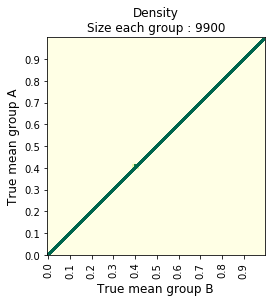

In [53]:
#for t in range(1, 100):
#    plot_joint_density(results_a[:t], results_b[:t], t, steps=100, save=True)

#for t in range(1, 100):
#    i = t * 100
#    plot_joint_density(results_a[:i], results_b[:i], i, steps=100, save=True)

In [54]:
t = 100
group_with_highest_mean, stop_test, loss_a, loss_b = proceed_baeysian_test(results_a[:t],
                                                                           results_b[:t],
                                                                           t)

loss A inf to epsilon : False
loss B inf to epsilon : False

mean group A : 0.45
mean group B : 0.43

proba mean B sup to mean A : 0.3612797915954386
proba mean A sup to mean B : 0.583606496560401



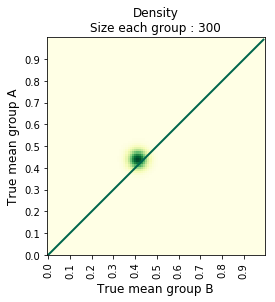

In [56]:
t = 300

res_a = results_a[:t]
res_b = results_b[:t]

plot_joint_density(res_a, res_b, t)